<a href="https://colab.research.google.com/github/cesar-claros/synergistic/blob/master/socialadsnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch
!pip install gpytorch

In [ ]:
! sudo apt-get install texlive-latex-recommended #1
! sudo apt-get install dvipng texlive-fonts-recommended #2
! wget http://mirrors.ctan.org/macros/latex/contrib/type1cm.zip #3
! unzip type1cm.zip -d /tmp/type1cm #4
! cd /tmp/type1cm/type1cm/ && sudo latex type1cm.ins  #5
! sudo mkdir /usr/share/texmf/tex/latex/type1cm #6
! sudo cp /tmp/type1cm/type1cm/type1cm.sty /usr/share/texmf/tex/latex/type1cm #7
! sudo texhash #8

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

In [5]:
!cp -r "drive/My Drive/NIPS2020/auxfunc/" .
!cp -r "drive/My Drive/NIPS2020/datasets/" .
!cp -r "drive/My Drive/NIPS2020/style/" .
!cp -r "drive/My Drive/NIPS2020/runs/" .

In [ ]:
%load_ext tensorboard

In [76]:
#%%
# Imports
import io #Used as buffer
import sys
import matplotlib
# matplotlib.use('qt5Agg')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import auxfunc.sigfunc as sgn
import seaborn as sns
import torch
import tensorflow as tf
from scipy.stats import entropy, spearmanr
from sklearn import model_selection, svm, ensemble, linear_model, pipeline, decomposition,\
     tree, neighbors, discriminant_analysis, gaussian_process, preprocessing
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, Matern
plt.style.use(['ggplot','style/style.mplstyle'])

In [77]:
#%%
# MODELS
# ====================
# Grid search for parameters and classifiers

models = { 
        'predictor':
            [
            svm.SVC(),
            gaussian_process.GaussianProcessClassifier(),
            linear_model.LinearRegression(),
            linear_model.Lasso(),
            svm.SVR()],
        'name':
            [
            'SVM',
            'GPClassifier',
            'LinReg',
            'Lasso',
            'SVR']}
parameters = [
            {'SVM__kernel':['poly'],'SVM__degree':[3,4,5]},
            {'GPClassifier__kernel':[]},
            {},
            {'Lasso__alpha':np.linspace(0.01,1,10)},
            {'SVR__kernel':['linear'], 'SVR__C':np.logspace(-1, 1, 10), 'SVR__epsilon':np.logspace(-2, 2, 10)} ]


In [78]:
#%%
# Signaling function fitting and evaluation
def signalingFunction(X_train, y_train, y_train_pred_th, X_val, y_val, y_val_pred_th, X_test, y_test, y_test_pred_th, kernel='exponential', norm='l01'):
    # X_train, X_val should be scaled
    # Fit signaling function 
    exp = sgn.signaling(norm=norm) # idx = [train,test,val]
    exp.fit(X_train, y_train, y_train_pred_th, kernel=kernel, n_iter=500, lr=0.01)
    table_val = exp.evaluate(X_val, y_val, y_val_pred_th, rule_grid=np.linspace(0,3,30, endpoint=False))
    table_test = exp.test(X_test, y_test, y_test_pred_th, table_val['rule'].to_numpy(), table_val['eta'].to_numpy())
    table = pd.concat([table_val,table_test],axis=1)
    return table, exp

In [79]:
#%%
# Initialize model
def init_model(input_dim, models, parameters, clf):
    
    if clf=='svm':
      i = 0
    elif clf=='gpc':
      i = 1
      kernel = 1.0 * RBF(length_scale=1.0*np.ones(input_dim)) 
      parameters[i]['GPClassifier__kernel'].append(kernel)
      
    scaler = preprocessing.StandardScaler()
    steps = [('scaler', scaler), (models['name'][i], models['predictor'][i])]
    ppline = pipeline.Pipeline(steps) # define the pipeline object.

    clf = model_selection.GridSearchCV(ppline, param_grid=parameters[i], cv=5, iid=False)
    return clf

In [80]:
#%%
# Soft and thresholded output predictions
def pred_output(model, X):
    if hasattr(model, "decision_function"):
      y_pred_soft = model.best_estimator_.decision_function(X)[:,None]
      y_pred_th = model.best_estimator_.predict(X)
    else:
      y_pred_soft = model.best_estimator_.predict_proba(X)
      y_pred_th = model.best_estimator_.predict(X)
    return y_pred_soft, y_pred_th

In [81]:
#%%
# Jaccard similarity index
def jaccard_similarity(list1, list2):
    s1 = set(list1)
    s2 = set(list2)
    return len(s1.intersection(s2)) / len(s1.union(s2))

In [82]:
#%%
# Baseline comparison
def baselineCriteria(y_val, y_val_pred_soft, y_val_pred_th, y_test, y_test_pred_soft, y_test_pred_th, table, exp, clf):
      if clf=='svm':
          direction = 'closer'
          crit_val = np.abs(y_val_pred_soft.ravel())
          crit_test = np.abs(y_test_pred_soft.ravel())
      else:
          direction = 'further'
          p_val = np.concatenate((y_val_pred_soft,1-y_val_pred_soft),axis=1)
          crit_val = entropy(p_val, axis=1, base=2)
          p_test = np.concatenate((y_test_pred_soft,1-y_test_pred_soft),axis=1)
          crit_test = entropy(p_test, axis=1, base=2)
      
      critFunc = sgn.critEvaluation(norm='l01',direction=direction)
      d_val = critFunc.evaluate(y_val, y_val_pred_th, crit_val)
      d_test = critFunc.test(y_test, y_test_pred_th, crit_test, d_val['thresh'].to_numpy())
      crit_table = pd.concat([d_val,d_test],axis=1)

      gamma = table['rule'].to_numpy().reshape(-1,1)
      f_test = exp.gpr_mean_test + gamma*np.sqrt(exp.gpr_var_test)
      eta = table['eta'].to_numpy().reshape(-1,1)
      theta = crit_table['thresh'].to_numpy().reshape(-1,1)
      if direction == 'closer':
        f_mask, f_idx = np.nonzero(f_test>eta)
      else:
        f_mask, f_idx = np.nonzero(f_test<eta)
      crit_mask, crit_idx = np.nonzero(crit_test.reshape(1,-1)<theta)
      print(list(np.unique(f_mask)))
      print(list(np.unique(crit_mask)))
      print(f_test.shape[0])
      shared = set(list(np.unique(f_mask))).intersection(set(list(np.unique(crit_mask))))
      J = [jaccard_similarity(crit_idx[crit_mask==i],f_idx[f_mask==i]) if i in shared else np.nan for i in range(f_test.shape[0])]
      # if (list(np.unique(f_mask))==list(np.unique(crit_mask))):
      #   J = [jaccard_similarity(crit_idx[crit_mask==i],f_idx[f_mask==i]) for i in np.unique(f_mask)]
      # else:
      #   shared = set(a).intersection(set(b))
      #   union = set(a).union(set(b))
      #   J = [jaccard_similarity(crit_idx[crit_mask==i],f_idx[f_mask==i]) if i in shared else np.nan  for i in union]
      crit_table['jaccard']=J
      Sp = [spearmanr(f_test[i,:],crit_test)[0] for i in range(f_test.shape[0])]
      crit_table['spearman'] = Sp
      crit_table['gamma'] = gamma
      return crit_table

In [123]:
#%%
# INITIALIZATION
# ==============
# EXPERIMENT SETUP
# ================
# Load data
# -------------
df = pd.read_table('datasets/Social_Network_Ads.csv')
Data_X = df.iloc[:,[2,3]]
Data_y = df.iloc[:,4]
Data_X = Data_X.to_numpy()
Data_y = Data_y.to_numpy()
# For reproducibility
tf.random.set_seed(54321)
np.random.seed(12345)
torch.manual_seed(0)

In [124]:
#%%
# Assign labels
report_table = []
report_criteria = []
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=123)
clf = 'gpc'
addPredictions = True
applyPCA = True
accuracy = 0
for sample, test in kf.split(Data_X):
    X = Data_X[sample]
    y = Data_y[sample]
    X_train, X_val, y_train, y_val = model_selection.train_test_split(X, y, test_size=0.20, random_state=123)
    X_test = Data_X[test]
    y_test = Data_y[test]

    # TRAINING MODEL
    model = init_model(input_dim=X.shape[1], models=models, parameters=parameters, clf=clf)
    model.fit(X_train, y_train)

    y_train_pred_soft, y_train_pred_th = pred_output(model, X_train)
    print('accuracy(Train)={}'.format(np.sum(y_train==y_train_pred_th)/np.size(y_train)))
    y_val_pred_soft, y_val_pred_th = pred_output(model, X_val)
    y_test_pred_soft, y_test_pred_th = pred_output(model, X_test)

    X_train_GP = X_train
    X_val_GP = X_val
    X_test_GP = X_test
    if addPredictions:
            # Add predictions
            X_train_GP = np.concatenate((X_train, y_train_pred_soft), axis=1)
            X_val_GP = np.concatenate((X_val, y_val_pred_soft), axis=1)
            X_test_GP = np.concatenate((X_test, y_test_pred_soft), axis=1)
    scaleX_GP = preprocessing.StandardScaler().fit(np.concatenate((X_train_GP, X_val_GP), axis=0))
    X_train_GP = scaleX_GP.transform(X_train_GP)
    X_val_GP = scaleX_GP.transform(X_val_GP)
    X_test_GP = scaleX_GP.transform(X_test_GP)
    if applyPCA:
            pca_GP = decomposition.PCA(.99).fit(np.concatenate((X_train_GP, X_val_GP), axis=0)) # set percentage of energy preserved by PCA
            # Apply PCA transform to all sets
            X_train_GP = pca_GP.transform(X_train_GP)
            X_val_GP = pca_GP.transform(X_val_GP)
            X_test_GP = pca_GP.transform(X_test_GP)
    
    table, exp = signalingFunction(X_train_GP, y_train, y_train_pred_th, X_val_GP, y_val, y_val_pred_th, X_test_GP, y_test, y_test_pred_th)
    report_table.append(table)
    
    # Baseline for comparison
    crit_table = baselineCriteria(y_val, y_val_pred_soft, y_val_pred_th, y_test, y_test_pred_soft, y_test_pred_th, table, exp, clf)
    report_criteria.append(crit_table)

    if accuracy < model.best_estimator_.score(X_val,y_val):
        accuracy = model.best_estimator_.score(X_val,y_val)
        classifier = model.best_estimator_
        X_test_surface_plot = X_test
        y_test_surface_plot = y_test
        X_train_surface_plot = X_train
        y_train_surface_plot = y_train
        X_val_surface_plot = X_val
        y_val_surface_plot = y_val
        scaler_surface_plot = scaleX_GP
        exp_surface_plot = exp
        table_surface_plot = table

    del(model)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


accuracy(Train)=0.9375
initializing cuda...
lr=0.01, n_iterations=500
Iter 491/500 - Loss: -0.009  noise: 0.049
Iter 492/500 - Loss: -0.009  noise: 0.049
Iter 493/500 - Loss: -0.009  noise: 0.049
Iter 494/500 - Loss: -0.009  noise: 0.049
Iter 495/500 - Loss: -0.009  noise: 0.049
Iter 496/500 - Loss: -0.009  noise: 0.049
Iter 497/500 - Loss: -0.009  noise: 0.049
Iter 498/500 - Loss: -0.009  noise: 0.049
Iter 499/500 - Loss: -0.009  noise: 0.049
Iter 500/500 - Loss: -0.009  noise: 0.049
evaluating with cuda...
evaluating with cuda...
[0, 1, 2, 3]
[0, 1, 2, 3]
4


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


accuracy(Train)=0.91015625
initializing cuda...
lr=0.01, n_iterations=500
Iter 491/500 - Loss: 0.079  noise: 0.052
Iter 492/500 - Loss: 0.079  noise: 0.052
Iter 493/500 - Loss: 0.079  noise: 0.052
Iter 494/500 - Loss: 0.079  noise: 0.052
Iter 495/500 - Loss: 0.079  noise: 0.052
Iter 496/500 - Loss: 0.078  noise: 0.052
Iter 497/500 - Loss: 0.078  noise: 0.052
Iter 498/500 - Loss: 0.078  noise: 0.052
Iter 499/500 - Loss: 0.078  noise: 0.052
Iter 500/500 - Loss: 0.078  noise: 0.052
evaluating with cuda...
evaluating with cuda...
[0, 1, 2, 3]
[0, 1, 2, 3]
4


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


accuracy(Train)=0.91015625
initializing cuda...
lr=0.01, n_iterations=500
Iter 491/500 - Loss: 0.028  noise: 0.043
Iter 492/500 - Loss: 0.028  noise: 0.043
Iter 493/500 - Loss: 0.028  noise: 0.043
Iter 494/500 - Loss: 0.027  noise: 0.043
Iter 495/500 - Loss: 0.027  noise: 0.043
Iter 496/500 - Loss: 0.027  noise: 0.043
Iter 497/500 - Loss: 0.027  noise: 0.043
Iter 498/500 - Loss: 0.027  noise: 0.043
Iter 499/500 - Loss: 0.027  noise: 0.043
Iter 500/500 - Loss: 0.027  noise: 0.043
evaluating with cuda...
evaluating with cuda...
[0, 1, 2, 3]
[0, 1, 2, 3]
4


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


accuracy(Train)=0.94140625
initializing cuda...
lr=0.01, n_iterations=500
Iter 491/500 - Loss: -0.051  noise: 0.043
Iter 492/500 - Loss: -0.051  noise: 0.043
Iter 493/500 - Loss: -0.051  noise: 0.043
Iter 494/500 - Loss: -0.051  noise: 0.043
Iter 495/500 - Loss: -0.052  noise: 0.043
Iter 496/500 - Loss: -0.052  noise: 0.044
Iter 497/500 - Loss: -0.052  noise: 0.044
Iter 498/500 - Loss: -0.052  noise: 0.044
Iter 499/500 - Loss: -0.052  noise: 0.044
Iter 500/500 - Loss: -0.052  noise: 0.044
evaluating with cuda...
evaluating with cuda...
[0, 1, 2, 3]
[0, 1, 2, 3]
4


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


accuracy(Train)=0.91796875
initializing cuda...
lr=0.01, n_iterations=500
Iter 491/500 - Loss: 0.049  noise: 0.048
Iter 492/500 - Loss: 0.049  noise: 0.048
Iter 493/500 - Loss: 0.049  noise: 0.048
Iter 494/500 - Loss: 0.049  noise: 0.048
Iter 495/500 - Loss: 0.049  noise: 0.047
Iter 496/500 - Loss: 0.049  noise: 0.047
Iter 497/500 - Loss: 0.049  noise: 0.047
Iter 498/500 - Loss: 0.049  noise: 0.047
Iter 499/500 - Loss: 0.049  noise: 0.047
Iter 500/500 - Loss: 0.049  noise: 0.047
evaluating with cuda...
evaluating with cuda...
[0, 1, 2, 3]
[0, 1, 2, 3]
4


In [ ]:
logs_base_dir = "runs/"
%tensorboard --logdir {logs_base_dir}

In [125]:
##%
# Boxplot (loss reduction in test set)
report_table_concat = pd.concat(report_table)
cols_table = ['p_value','rho_user','%reduction_test']
df_boxplot_table = pd.DataFrame(report_table_concat[cols_table])
df_boxplot_table['label'] = df_boxplot_table.shape[0]*['$f(x)$']
report_criteria_concat = pd.concat(report_criteria)
columns_crit = ['rho_user','%reduction_test']
df_boxplot_crit = pd.DataFrame(report_criteria_concat[columns_crit])
df_boxplot_crit['label'] = df_boxplot_crit.shape[0]*['$g(x)$']
# p-value median
p_value_col = df_boxplot_table['p_value'] #Add
p_value_by_row_index = df_boxplot_table['p_value'].groupby(df_boxplot_table.index)
p_value_median = p_value_by_row_index.median()
# Boxplot (jaccard index in test set)
columns_jac = ['rho_user','jaccard']
df_jaccard = pd.DataFrame(report_criteria_concat[columns_jac])
# Unfiltered Result dataframes
cols_fx = ['rho_user','%reduction_val','budget','%reduction_test']
results_fx = pd.DataFrame(report_table_concat[cols_fx])
cols_fxgx = ['rho_user','%reduction_test', 'jaccard']
results_fxgx = pd.concat([df_boxplot_table[cols_fxgx[:2]], df_boxplot_crit[cols_fxgx[1]], \
                          df_jaccard[cols_fxgx[2]]], axis=1)
# Filter experiments with p_value > 0.05
df_boxplot_crit = df_boxplot_crit.loc[df_boxplot_table['p_value'] <= 0.05]
df_jaccard = df_jaccard.loc[df_boxplot_table['p_value'] <= 0.05]
df_boxplot_table = df_boxplot_table.loc[df_boxplot_table['p_value'] <= 0.05]
# Boxplot with filtered values only
frames = [df_boxplot_table, df_boxplot_crit]
df = pd.concat(frames)

In [126]:
# Avoid plotting when median(p_value)>0.5
for i in range(p_value_median.shape[0]):
    if p_value_median.iloc[i]>0.05:
      df.loc[df.index==i,'%reduction_test'] = np.nan
      df_jaccard.loc[df_jaccard.index==i, 'jaccard'] = np.nan

In [127]:
# Dataframe for results f(x)
results_fx = results_fx.loc[p_value_col <= 0.05].copy()
results_fx_by_row_index = results_fx.groupby(results_fx.index)
fx_median = results_fx_by_row_index.median()
fx_q1 = results_fx_by_row_index.quantile(q=0.25)
fx_q3 = results_fx_by_row_index.quantile(q=0.75)
# Signaling function statistics (median(q1-q3)) LaTex
output_fx = io.StringIO()
numRows = fx_median.shape[0]
numCols = fx_median.shape[1]
output_fx.write("results_fx (\\rho|%reduction_val|sig_rate|%reduction_test|H0)\n")
output_fx.write("----------\n")
for i in range(numRows):
  row = [r'{:.2f}'.format(val1) if p_value_median[i]>0.05 and j==0 else r'{}' if p_value_median[i]>0.05 and j!=0\
         else r'{:.2f}'.format(val1) if (j==0) else r'{:.2f}({:.2f}-{:.2f})'.format(val1,val2,val3) if (j==2)\
         else r'{:.1f}({:.1f}-{:.1f})'.format(val1,val2,val3) for val1,val2,val3,j in zip(fx_median.iloc[i],fx_q1.iloc[i],fx_q3.iloc[i],range(numCols))]
  output_fx.write("{{}} & {{}} & %s & {H0} \\\\\n".format(H0=r'$\surd$' if p_value_median[i]<=0.05 else r'$\times$')%(" & ".join(row)))
print(output_fx.getvalue())

results_fx (\rho|%reduction_val|sig_rate|%reduction_test|H0)
----------
{} & {} & 0.05 & 25.0(24.3-26.2) & 0.06(0.04-0.06) & 18.1(8.3-25.0) & $\surd$ \\
{} & {} & 0.10 & 37.5(37.5-44.4) & 0.09(0.06-0.10) & 22.2(20.0-25.0) & $\surd$ \\
{} & {} & 0.15 & 37.5(37.5-55.6) & 0.14(0.09-0.15) & 22.2(20.0-25.0) & $\surd$ \\
{} & {} & 0.20 & 52.8(47.9-56.7) & 0.14(0.09-0.19) & 26.1(20.8-41.2) & $\surd$ \\



In [128]:
# Dataframe for comparison f(x)-g(x)
results_fxgx = results_fxgx.loc[p_value_col <= 0.05]
results_fxgx_by_row_index = results_fxgx.groupby(results_fxgx.index)
fxgx_median = results_fxgx_by_row_index.median()
fxgx_q1 = results_fxgx_by_row_index.quantile(q=0.25)
fxgx_q3 = results_fxgx_by_row_index.quantile(q=0.75)
# Baseline comparison statistics (median(q1-q3)) LaTex
output_fxgx = io.StringIO()
numRows = fxgx_median.shape[0]
numCols = fxgx_median.shape[1]
output_fxgx.write("results_fxgx (\\rho|%reduction_test(fx)|%reduction_test(fxgx)|Jaccard|H0\n")
output_fxgx.write("------------\n")
for i in range(numRows):
  row = [r'{:.2f}'.format(val1) if p_value_median[i]>0.05 and j==0 else r'{}' if p_value_median[i]>0.05 and j!=0\
         else r'{:.2f}'.format(val1) if (j==0) else r'{:.2f}({:.2f}-{:.2f})'.format(val1,val2,val3) if (j==3)\
         else r'{:.1f}({:.1f}-{:.1f})'.format(val1,val2,val3) for val1,val2,val3,j in zip(fxgx_median.iloc[i],fxgx_q1.iloc[i],fxgx_q3.iloc[i],range(numCols))]
  output_fxgx.write("{{}} & {{}} & %s & {H0} \\\\\n".format(H0=r'$\surd$' if p_value_median[i]<=0.05 else r'$\times$')%(" & ".join(row)))
print(output_fxgx.getvalue())

results_fxgx (\rho|%reduction_test(fx)|%reduction_test(fxgx)|Jaccard|H0
------------
{} & {} & 0.05 & 18.1(8.3-25.0) & 18.8(9.4-32.6) & 0.92(0.92-0.93) & $\surd$ \\
{} & {} & 0.10 & 22.2(20.0-25.0) & 25.0(10.0-50.0) & 0.92(0.91-0.94) & $\surd$ \\
{} & {} & 0.15 & 22.2(20.0-25.0) & 25.0(10.0-55.6) & 0.94(0.92-0.95) & $\surd$ \\
{} & {} & 0.20 & 26.1(20.8-41.2) & 32.5(22.9-43.9) & 0.89(0.88-0.91) & $\surd$ \\



In [129]:
#%%
# Save results in csv fomat
path_csv = "drive/My Drive/NIPS2020/results/socialadsnet/results_{clf}_yhat{yhat}_pca{pca}.csv".format(clf=clf, pca=applyPCA, yhat=addPredictions)
results = pd.concat([results_fx, results_fxgx, p_value_col.loc[p_value_col <= 0.05]], keys=['fx', 'fxgx', ''], axis=1).to_csv(path_csv, index=True, header=True)
# modified output
# Save results in tex fomat
L = [output_fx.getvalue(),output_fxgx.getvalue()]
path_txt = "drive/My Drive/NIPS2020/results/socialadsnet/results_{clf}_yhat{yhat}_pca{pca}.txt".format(clf=clf, pca=applyPCA, yhat=addPredictions)
txt = open(path_txt, "w") 
txt.writelines(L) 
txt.close() #to change file access modes 

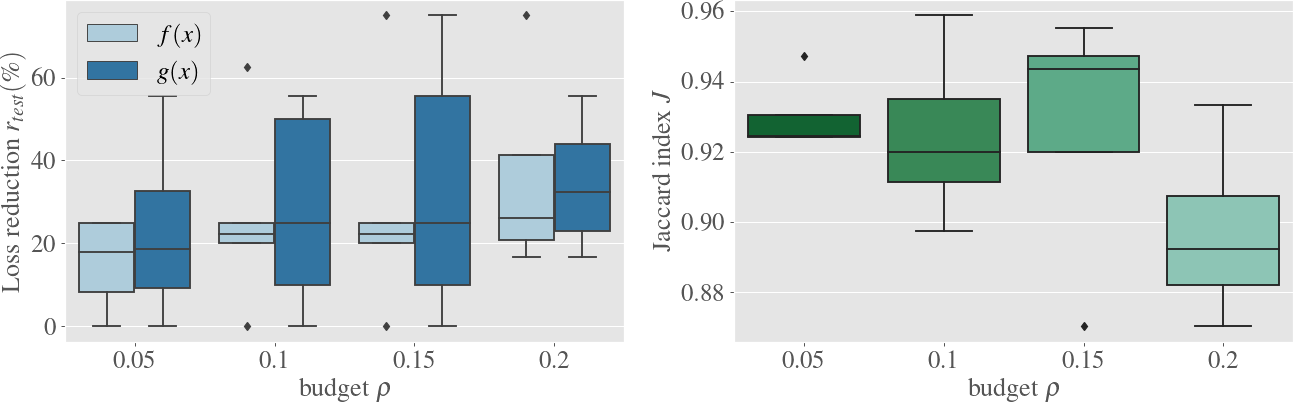

In [130]:
fig, ax = plt.subplots(1,2,figsize=(15, 5.1), constrained_layout=False, dpi=90)
pal = sns.color_palette('Paired')
sns.boxplot(x=df['rho_user'], y=df['%reduction_test'], hue='label', data=df, ax=ax[0], palette=pal)
ax[0].set_xlabel(r'budget $\rho$')
ax[0].set_ylabel(r'Loss reduction $r_{test}(\%)$')
ax[0].legend(loc='upper left')
pal = sns.color_palette('BuGn_r')
sns.boxplot(x=df_jaccard['rho_user'], y=df_jaccard['jaccard'], data=df_jaccard, ax=ax[1], palette=pal)
ax[1].set_xlabel(r'budget $\rho$')
ax[1].set_ylabel(r'Jaccard index $J$')
plt.tight_layout()
path_fig_fxgx = "drive/My Drive/NIPS2020/results/socialadsnet/fig_fxgx_{clf}_yhat{yhat}_pca{pca}.pdf".format(clf=clf, pca=applyPCA, yhat=addPredictions)
plt.savefig(path_fig_fxgx, bbox_inches='tight', facecolor='w')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: The following kwargs were not used by contour: 'label'
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


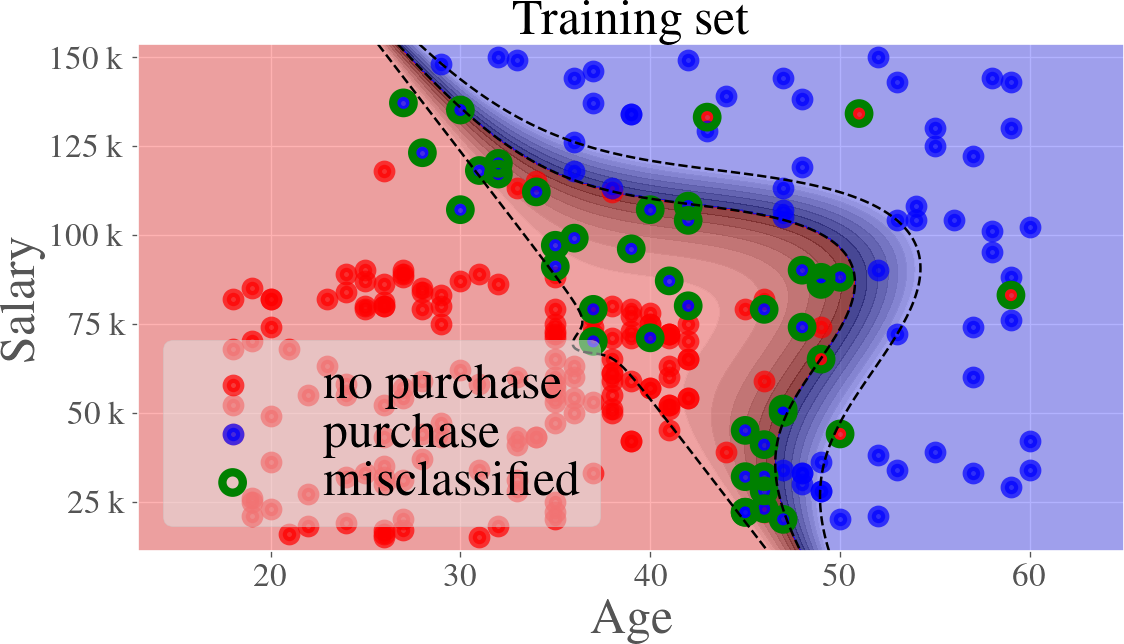

In [ ]:
  #%%
# PLOT DECISION SURFACE
# ==================
# Plot test instances and decision surface
# ----------------------------------------------
# Visualising the Train set results
fig1 = plt.figure(figsize=(10,6),dpi=120)
ax1 = fig1.add_subplot(111)
X_set, y_set = X_train_surface_plot, y_train_surface_plot
y_set[y_set==0] = -1
if hasattr(classifier, "decision_function"):
    d_set = 1-y_set*classifier.decision_function(X_set)
else:
    pred_x = classifier.predict(X_set)
    pred_x[pred_x==0] = -1
    d_set = y_set*pred_x
xi_set = np.max([[np.zeros(d_set.size)],[d_set]],axis=0).ravel()

aranged_ages = np.arange(start = X_set[:, 0].min()-5, stop = X_set[:, 0].max()+5, step = 0.025)
aranged_salaries = np.arange(start = X_set[:, 1].min()-4000, stop = X_set[:, 1].max()+4000, step = 500)

X1, X2 = np.meshgrid(aranged_ages, aranged_salaries)
Z = classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape)
if hasattr(classifier, "decision_function"):
    d = classifier.decision_function(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape)
    ax1.contourf(X1, X2, np.where((np.abs(d)<1),np.abs(d),np.nan), alpha = 0.6, cmap='gist_gray', label='margin region')
    ax1.contour(X1, X2, d, levels=[-1, 0, 1], colors='black', linestyles='dashed')
    ax1.contourf(X1, X2, Z, alpha = 0.3, cmap = matplotlib.colors.ListedColormap(('red', 'blue')))
    x = X_set[xi_set>1,0]
    y = X_set[xi_set>1,1]
else:
    d = classifier.predict_proba(np.array([X1.ravel(), X2.ravel()]).T)[:, 1].reshape(X1.shape)-0.5
    ax1.contourf(X1, X2, np.where((np.abs(d)<0.25),np.abs(d),np.nan), alpha = 0.6, cmap='gist_gray', label='margin region')
    ax1.contour(X1, X2, d, levels=[-0.25, 0.0, 0.25], colors='black', linestyles='dashed')
    ax1.contourf(X1, X2, Z, alpha = 0.3, cmap = matplotlib.colors.ListedColormap(('red', 'blue')))
    x = X_set[xi_set==0,0]
    y = X_set[xi_set==0,1]
dots = ['red','blue']
for i, j in enumerate(np.unique(y_set)):
    ax1.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                color = dots[i], label = '{}'.format('no purchase' if i==0 else 'purchase'),alpha=0.7, s=65, linewidths=5)
# Plot slack variables magnitudes
ax1.scatter(x, y, s=150, facecolors='none', edgecolors='g', label='misclassified', linewidths=5)

ax1.set_xlabel('Age', fontsize=30)
ax1.set_ylabel('Salary', fontsize=30)
ax1.set_title('Training set', fontsize=30)
ax1.legend(loc='lower left', framealpha=0.5, prop={'size': 30}, labelspacing=0.0)
formatter0 = matplotlib.ticker.EngFormatter()
ax1.yaxis.set_major_formatter(formatter0)
X1_min, X1_max = X1.min(), X1.max()
X2_min, X2_max = X2.min(), X2.max()
ax1.set_xlim(X1_min, X1_max)
ax1.set_ylim(X2_min, X2_max)
plt.tight_layout()
path_fig_fx_train = "drive/My Drive/NIPS2020/results/socialadsnet/fig_fx_train_{clf}_yhat{yhat}_pca{pca}.pdf".format(clf=clf, pca=applyPCA, yhat=addPredictions)
plt.savefig(path_fig_fx_train, bbox_inches='tight', facecolor='w')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: The following kwargs were not used by contour: 'label'


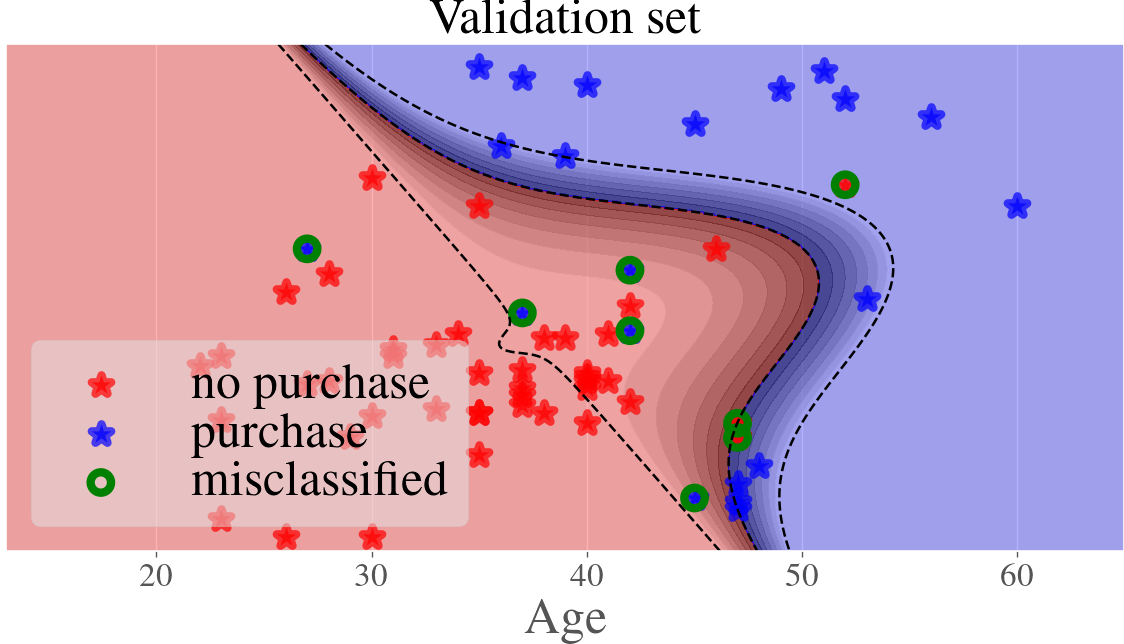

In [ ]:
#%%
# PLOT DECISION SURFACE
# ==================
# Plot test instances and decision surface
# ----------------------------------------------
# Visualising the Train set results
fig1 = plt.figure(figsize=(10,6),dpi=120)
ax1 = fig1.add_subplot(111)
X_set, y_set = X_val_surface_plot, y_val_surface_plot
y_set[y_set==0] = -1
if hasattr(classifier, "decision_function"):
    d_set = 1-y_set*classifier.decision_function(X_set)
else:
    pred_x = classifier.predict(X_set)
    pred_x[pred_x==0] = -1
    d_set = y_set*pred_x
xi_set = np.max([[np.zeros(d_set.size)],[d_set]],axis=0).ravel()
if hasattr(classifier, "decision_function"):
    d = classifier.decision_function(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape)
    ax1.contourf(X1, X2, np.where((np.abs(d)<1),np.abs(d),np.nan), alpha = 0.6, cmap='gist_gray', label='margin region')
    ax1.contour(X1, X2, d, levels=[-1,0,1], colors='black', linestyles='dashed')
    ax1.contourf(X1, X2, Z, alpha = 0.3, cmap = matplotlib.colors.ListedColormap(('red', 'blue')))
    x = X_set[xi_set>1,0]
    y = X_set[xi_set>1,1]
else:
    d = classifier.predict_proba(np.array([X1.ravel(), X2.ravel()]).T)[:, 1].reshape(X1.shape)-0.5
    ax1.contourf(X1, X2, np.where((np.abs(d)<0.25),np.abs(d),np.nan), alpha = 0.6, cmap='gist_gray', label='margin region')
    ax1.contour(X1, X2, d, levels=[-0.25, 0, 0.25], colors='black', linestyles='dashed')
    ax1.contourf(X1, X2, Z, alpha = 0.3, cmap = matplotlib.colors.ListedColormap(('red', 'blue')))
    x = X_set[xi_set==0,0]
    y = X_set[xi_set==0,1]

dots = ['red','blue']
for i, j in enumerate(np.unique(y_set)):
    ax1.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                color = dots[i], label = '{}'.format('no purchase' if i==0 else 'purchase'),alpha=0.7,s=150, marker='*', linewidths=5)
# Plot slack variables magnitudes
ax1.scatter(x, y, s=150, facecolors='none', edgecolors='g', label='misclassified', linewidths=5)
 
ax1.set_xlabel('Age',fontsize=30)
ax1.set_yticks([])
ax1.set_title('Validation set',fontsize=30)
ax1.legend(loc='lower left', framealpha=0.5, prop={'size': 30},labelspacing=0.0)
ax1.set_xlim(X1_min, X1_max)
ax1.set_ylim(X2_min, X2_max)
plt.tight_layout()
path_fig_fx_val = "drive/My Drive/NIPS2020/results/socialadsnet/fig_fx_val_{clf}_yhat{yhat}_pca{pca}.pdf".format(clf=clf, pca=applyPCA, yhat=addPredictions)
plt.savefig(path_fig_fx_val, bbox_inches='tight', facecolor='w')

evaluating with cuda...


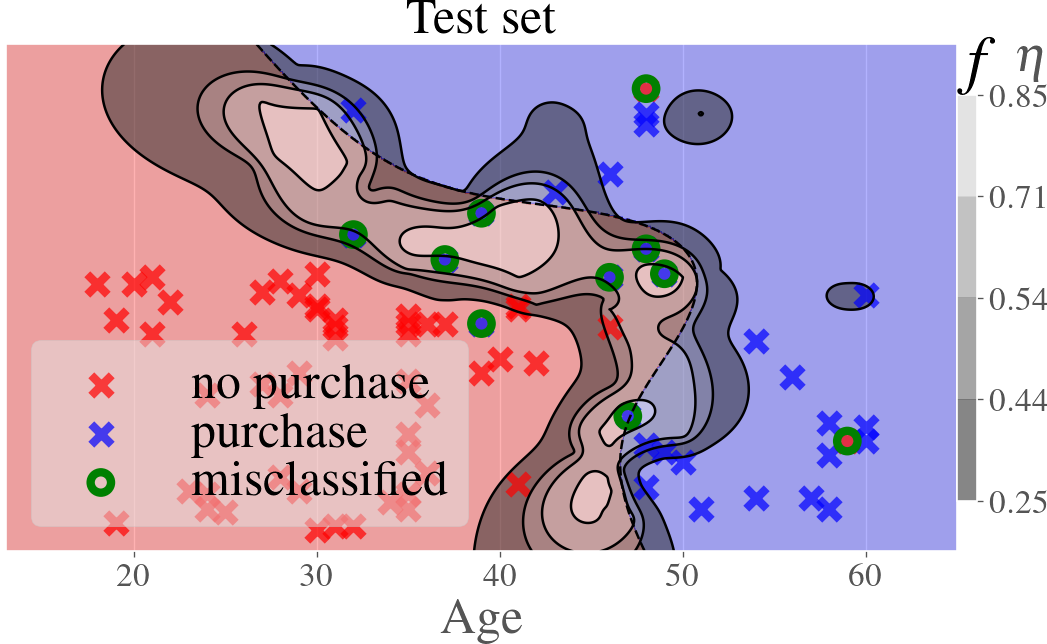

In [ ]:
t = np.stack((X1.ravel(), X2.ravel()), axis=1)
t_scaled = scaler_surface_plot.transform(t)
f,v = exp_surface_plot.gpr.predict(t_scaled)
f = f.reshape(X1.shape)
# PLOT DECISION SURFACE
# ==================
# Plot test instances and decision surface
# ----------------------------------------------
# Visualising the Test set results
fig1 = plt.figure(figsize=(10,6),dpi=120)
ax1 = fig1.add_subplot(111)
X_set, y_set = X_test_surface_plot, y_test_surface_plot
y_set[y_set==0] = -1
if hasattr(classifier, "decision_function"):
    d_set = 1-y_set*classifier.decision_function(X_set)
else:
    pred_x = classifier.predict(X_set)
    pred_x[pred_x==0] = -1
    d_set = y_set*pred_x
xi_set = np.max([[np.zeros(d_set.size)],[d_set]],axis=0).ravel()
if hasattr(classifier, "decision_function"):
    d = classifier.decision_function(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape)
    ax1.contour(X1, X2, d, levels=[0], colors='black', linestyles='dashed')
    ax1.contourf(X1, X2, Z, alpha = 0.3, cmap = matplotlib.colors.ListedColormap(('red', 'blue')))
    x = X_set[xi_set>1,0]
    y = X_set[xi_set>1,1]
else:
    d = classifier.predict_proba(np.array([X1.ravel(), X2.ravel()]).T)[:, 1].reshape(X1.shape)
    ax1.contour(X1, X2, d, levels=[0.5], colors='black', linestyles='dashed')
    ax1.contourf(X1, X2, Z, alpha = 0.3, cmap = matplotlib.colors.ListedColormap(('red', 'blue')))
    x = X_set[xi_set==0,0]
    y = X_set[xi_set==0,1]

f_set = table_surface_plot['eta'].to_numpy()[::-1]
f_set = np.unique(np.around(np.append(f_set, f.max()), decimals=2))
cs = ax1.contourf(X1, X2, f, f_set, origin='upper', cmap='gray', alpha=0.5)
ax1.contour(X1, X2, f, f_set, colors='black')
cbar = fig1.colorbar(cs, pad=0.0, shrink=0.80)
cbar.ax.set_title(r'$f$', fontsize=40, loc='left')
cbar.set_label(r'$\eta$', labelpad=-10, y=1.14, rotation=0, fontsize=30)
dots = ['red','blue']
for i, j in enumerate(np.unique(y_set)):
    ax1.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                color = dots[i], label = '{}'.format('no purchase' if i==0 else 'purchase'), alpha=0.7, s=150,marker='x', linewidth=5)
# Plot slack variables magnitudes
ax1.scatter(x, y, s=150, facecolors='none', edgecolors='g', label='misclassified', linewidths=5)

ax1.set_xlabel('Age',fontsize=30)
ax1.set_yticks([])
ax1.set_title('Test set',fontsize=30)
ax1.legend(loc='lower left', framealpha=0.5, prop={'size': 30}, labelspacing=0.0)
ax1.set_xlim(X1_min, X1_max)
ax1.set_ylim(X2_min, X2_max)
plt.tight_layout()
path_fig_fx_test = "drive/My Drive/NIPS2020/results/socialadsnet/fig_fx_test_{clf}_yhat{yhat}_pca{pca}.pdf".format(clf=clf, pca=applyPCA, yhat=addPredictions)
plt.savefig(path_fig_fx_test, bbox_inches='tight', facecolor='w')

In [ ]:
report_table_concat = pd.concat(report_table)
table_by_row_index = report_table_concat.groupby(report_table_concat.index)
report_table_mean = table_by_row_index.mean()
report_table_std = table_by_row_index.std()
report_table_median = table_by_row_index.median()
report_table_q1 = table_by_row_index.quantile(q=0.25)
report_table_q3 = table_by_row_index.quantile(q=0.75)

report_criteria_concat = pd.concat(report_criteria)
table_by_row_index = report_criteria_concat.groupby(report_criteria_concat.index)
report_criteria_mean = table_by_row_index.mean()
report_criteria_std = table_by_row_index.std()
report_criteria_median = table_by_row_index.median()
report_criteria_q1 = table_by_row_index.quantile(q=0.25)
report_criteria_q3 = table_by_row_index.quantile(q=0.75)

In [ ]:
##%
# Signaling function statistics (median(q1-q3))
output = io.StringIO()
columns = ['%reduction_val','budget','%reduction_test']
df1 = report_table_median[columns]
df2 = report_table_q1[columns]
df3 = report_table_q3[columns]
pval = report_table_mean['p_value']
rho = report_table_mean['rho_user']
assert(df1.shape[0]==df2.shape[0])
numRows = df1.shape[0]
for i in range(numRows):
  row = [r'{:.1f}({:.1f}-{:.1f})'.format(val1,val2,val3) if pval[i]<=0.05 and j!=1 else r'{:.2f}({:.2f}-{:.2f})'.format(val1,val2,val3)\
       if pval[i]<=0.05 and j==1 else r'{}' for val1,val2,val3,j in zip(df1.iloc[i],df2.iloc[i],df3.iloc[i],range(len(columns)))]
  output.write("{{}} & {{}} & {rho:.2f} & %s & {H0} \\\\\n".format(rho=rho[i], H0=r'$\surd$' if pval[i]<=0.05 else r'$\times$')%(" & ".join(row)))
print(output.getvalue())

In [ ]:
##%
# Signaling function statistics (mean+/-std)
output = io.StringIO()
columns = ['%reduction_val','budget','%reduction_test']
df1 = report_table_mean[columns]
df2 = report_table_std[columns]
pval = report_table_mean['p_value']
rho = report_table_mean['rho_user']
assert(df1.shape[0]==df2.shape[0])
numRows = df1.shape[0]
for i in range(numRows):
  row = [r'{:.1f}$\pm${:.1f}'.format(val1,val2) if pval[i]<=0.05 and j!=1 else r'{:.2f}$\pm${:.2f}'.format(val1,val2)\
       if pval[i]<=0.05 and j==1 else r'{}' for val1,val2,j in zip(df1.iloc[i],df2.iloc[i],range(len(columns)))]
  output.write("{{}} & {{}} & {rho:.2f} & %s & {H0} \\\\\n".format(rho=rho[i], H0=r'$\surd$' if pval[i]<=0.05 else r'$\times$')%(" & ".join(row)))
print(output.getvalue())

In [ ]:
##%
# Comparison statistics (median(q1-q3))
output = io.StringIO()
shared = ['%reduction_test']
df1 = report_table_median[shared]
df2 = report_table_q1[shared]
df3 = report_table_q3[shared]
shared.append('jaccard')
df4 = report_criteria_median[shared]
df5 = report_criteria_q1[shared]
df6 = report_criteria_q3[shared]
pval = report_table_mean['p_value']
rho = report_table_mean['rho_user']
assert(df1.shape[0]==df3.shape[0])
numRows = df1.shape[0]
for i in range(numRows):
  row_table = [r'{:.1f}({:.1f}-{:.1f})'.format(val1,val2,val3) if pval[i]<=0.05 else r'{}' for val1,val2,val3 in zip(df1.iloc[i],df2.iloc[i],df3.iloc[i])]
  row_criteria = [r'{:.1f}({:.1f}-{:.1f})'.format(val4,val5,val6) if pval[i]<=0.05 and j==0 else r'{:.2f}({:.2f}-{:.2f})'.format(val4,val5,val6)\
                  if pval[i]<=0.05 and j==1 else r'{}' for val4,val5,val6,j in zip(df4.iloc[i],df5.iloc[i],df6.iloc[i],range(len(columns)))]
  # row =  []
  output.write("{{}} & {{}} & {rho:.2f} & %s & %s & {H0} \\\\\n".format(rho=rho[i], \
                H0=r'$\surd$' if pval[i]<=0.05 else r'$\times$')%(" & ".join(row_table), " & ".join(row_criteria)))
print(output.getvalue())

In [ ]:
##%
# Comparison statistics (mean+/-std)
output = io.StringIO()
shared = ['%reduction_test']
df1 = report_table_mean[shared]
df2 = report_table_std[shared]
shared.append('jaccard')
df3 = report_criteria_mean[shared]
df4 = report_criteria_std[shared]
pval = report_table_mean['p_value']
rho = report_table_mean['rho_user']
assert(df1.shape[0]==df3.shape[0])
numRows = df1.shape[0]
for i in range(numRows):
  row_table = [r'{:.1f}$\pm${:.1f}'.format(val1,val2) if pval[i]<=0.05 else r'{}' for val1,val2 in zip(df1.iloc[i],df2.iloc[i])]
  row_criteria = [r'{:.1f}$\pm${:.1f}'.format(val3,val4) if pval[i]<=0.05 and j==0 else r'{:.2f}$\pm${:.2f}'.format(val3,val4)\
                  if pval[i]<=0.05 and j==1 else r'{}' for val3,val4,j in zip(df3.iloc[i],df4.iloc[i],range(len(columns)))]
  # row =  []
  output.write("{{}} & {{}} & {rho:.2f} & %s & %s & {H0} \\\\\n".format(rho=rho[i], \
                H0=r'$\surd$' if pval[i]<=0.05 else r'$\times$')%(" & ".join(row_table), " & ".join(row_criteria)))
print(output.getvalue())

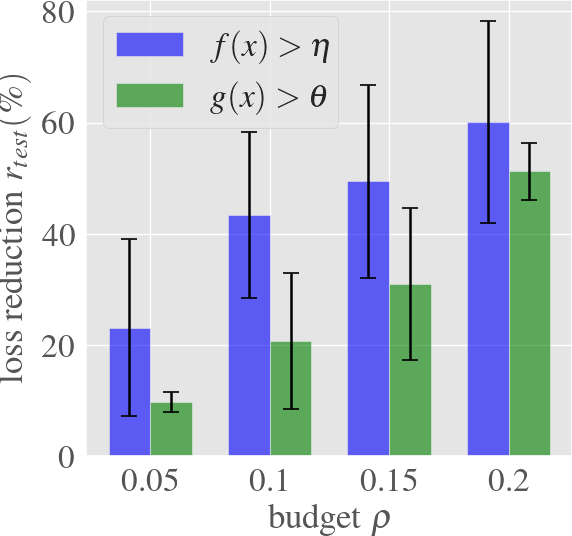

In [ ]:
# data to plot
means_table = report_table_mean['%reduction_test'].to_numpy()
means_table[pval>0.05]=0
std_table = report_table_std['%reduction_test'].to_numpy()
std_table[pval>0.05]=0
means_crit = report_criteria_mean['%reduction_test'].to_numpy()
means_crit[pval>0.05]=0
std_crit = report_criteria_std['%reduction_test'].to_numpy()
std_crit[pval>0.05]=0
n_groups = means_table.size

# create plot
fig, ax = plt.subplots(figsize=(5.4, 5.1), constrained_layout=False, dpi=120)
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.6

rects1 = plt.bar(index, means_table, bar_width, yerr=std_table, capsize=5,
alpha=opacity, color='b', label=r'$f(x)>\eta$')

rects2 = plt.bar(index + bar_width, means_crit, bar_width, yerr=std_crit, capsize=5,
alpha=opacity, color='g', label=r'$g(x)>\theta$')

plt.xlabel(r'budget $\rho$')
plt.ylabel(r'loss reduction $r_{test}(\%)$')
# plt.title('Scores by person')
plt.xticks(index + bar_width/2, (['{}'.format(i) for i in report_table_mean['rho_user'].to_numpy()]))
plt.legend()

plt.tight_layout()
plt.show()